# Principal Component Analysis with `python3`

## Preliminaries



`python3` offers a wide range of packages to perform ML and DL tasks:
+ [`numpy`](https://numpy.org/)
+ [`pandas`, Python Data Analysis Library](https://pandas.pydata.org/)
+ [`scikit-learn`, Machine Learning in Python](https://scikit-learn.org/stable/index.html)

In  the followig, we are going to exploit those tools to solve create non-parametric models to predict some quantities of interest. Let's upload those packages:

In [68]:
from IPython.display import Image

import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

Before getting started, a few general hints:

1. `lambda` constructors: they are used in `python` to define anonymous functions ([see this link](https://realpython.com/python-lambda/))




In [3]:
arr = np.array([1.5, 2.8, 3.1])
scale = lambda x: x * 3 
scale(arr)

array([4.5, 8.4, 9.3])

2. Handle `pandas` dataframe

In [4]:
Image(url="https://www.tutorialspoint.com/python_pandas/images/structure_table.jpg",width=500)

In [5]:
# Empty dataframe
df = pd.DataFrame()
print(df)

Empty DataFrame
Columns: []
Index: []


In [6]:
# Basic database
data = [1,2,3,4,5]
df = pd.DataFrame(data)
print(df)

   0
0  1
1  2
2  3
3  4
4  5


In [7]:
# Database with column labels
data = [['Alex',10],['Bob',12],['Clarke',13]]
df = pd.DataFrame(data,columns=['Name','Age'])
print(df)

     Name  Age
0    Alex   10
1     Bob   12
2  Clarke   13


In [8]:
# Repartitioning data into dataframe
data = [['Alex',10],['Bob',12],['Clarke',13]]
df = pd.DataFrame(data,columns=['Name','Age'],dtype=float)
print(df)

     Name   Age
0    Alex  10.0
1     Bob  12.0
2  Clarke  13.0


/tmp/ipykernel_16681/202426218.py:3: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df = pd.DataFrame(data,columns=['Name','Age'],dtype=float)


In [9]:
# Deal with indices
data = {'Name':['Tom', 'Jack', 'Steve', 'Ricky'],'Age':[28,34,29,42]}
df = pd.DataFrame(data, index=['rank1','rank2','rank3','rank4'])
print(df)

        Name  Age
rank1    Tom   28
rank2   Jack   34
rank3  Steve   29
rank4  Ricky   42


3. plot data: ([see this link](https://matplotlib.org/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py))



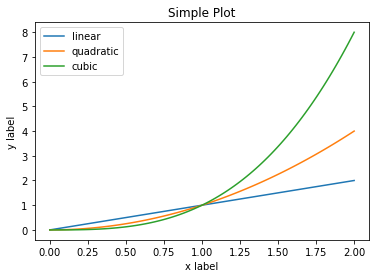

In [10]:
x = np.linspace(0, 2, 100)
plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("Simple Plot")
plt.legend()
plt.show()

## Dataset

In this work, the Finite Element model of a masonry building is considered, that is schematized in the figure below:

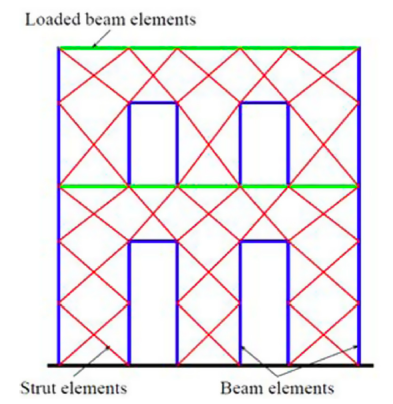

In [11]:
Image(filename="../imgs/masonry_building.png",width=400)

The behavior of this structure is simulated on the basis of non-linear dynamic FE analysis, all details of the model are well described in [1]. Using the FEM model, the inter-storey drifts of the building were calculated using 168 different earthquakes. Those inter-storey drift simulations represent the Engineering Demand parameters ED (matrix of $[1 \times 168]$) and they were computed by inputting 168 stochastic realizations of earthquake time-histories, obtained combining 13 different Intensity Measures (IM) proxies (IM: matrix of $[13\times168]$). 

The input databases are in file `mansonry_building_database.mat` [you can download here](https://github.com/FilLTP89/teaching/blob/master/datasets/mansonry_building_database.mat).

### Parse the dabase

In the following section, the database is parsed by loading it as a python dictionary:

In [6]:
from scipy.io import loadmat
link_to_mat_file="../datasets/mansonry_building_database.mat"
database=loadmat(link_to_mat_file)

In [11]:
IM=database['IM']
ED=database['ED']
print(IM.shape)
print(ED.shape)


(13, 168)
(1, 168)
        0        1         2         3        4         5        6    \
0  1.917138  1.22818  0.674447  0.635894  1.02625  0.784613  1.60802   

        7         8        9    ...       158       159       160       161  \
0  1.439748  0.749673  0.52682  ...  0.272101  0.579133  0.931796  0.959168   

       162       163       164       165       166       167  
0  0.77508  0.655644  0.649102  1.224109  0.980304  0.589991  

[1 rows x 168 columns]


## Principal Component Analysis

### Theoretical aspects

Imagine recording a phenomenon, described by $n$ variables $\left\lbrace x_i \right\rbrace_{i=1}^n$. Those $n$-dimensional observational data are observed $t$ times. The observations are stored in a $t\times n$ matrix $\mathbf{X}$, with $t$ observations for each of the $n$ variables:
$$\mathbf{X}=\begin{bmatrix} x_1^{(1)} & x_2^{(1)} & \ldots & x_n^{(1)}\\ x_1^{(2)} & x_2^{(2)} & \ldots & x_n^{(2)}\\ \ldots & \ldots & \ldots & \ldots\\ x_1^{(t)} & x_2^{(t)} & \ldots & x_n^{(t)}\\ \end{bmatrix} $$

The average values of each variable are stored in a $n\times 1$ vector called $\boldsymbol{\mu}_x$ :
$$\boldsymbol{\mu}_x^T=\begin{bmatrix} \frac{1}{n}\sum_{i=1}^t x_1^{(i)} & \frac{1}{n}\sum_{i=1}^t x_2^{(i)} & \ldots \frac{1}{n}\sum_{i=1}^t x_n^{(i)}  \end{bmatrix}$$

The $n\times n$ variance-covariance matrix $\mathbf{V}_{xx}$ reads instead:
$$\mathbf{V}_{xx}= \boldsymbol{X}^T\boldsymbol{\Delta}\boldsymbol{X}-\boldsymbol{\mu}_x \boldsymbol{\mu}_x^T$$

$\boldsymbol{\Delta}$ is the weight matrix and it is generally equal to $\frac{1}{n}\boldsymbol{I}$

The correlation matrix $\mathbf{R}_{xx}$ can be written as: 
$$\mathbf{R}_{xx}=\mathbf{D}_{xx}^{-\frac{1}{2}}\mathbf{V}_{xx}\mathbf{D}_{xx}^{-\frac{1}{2}}$$
where $\mathbf{D}_{xx}$ represents the diagonal of $\mathbf{V}_{xx}$

__EXERCISE__

From now on, consider $\mathbf{X}$ including both ED and IM as variables.
1. Plot the ED and IM distributions in separate figures.
2. Compute $\boldsymbol{\mu}_x$ 
3. Compute $\mathbf{V}_{xx}$ assuming $\boldsymbol{\Delta}=\frac{1}{n}\boldsymbol{I}$
4. Compute $\mathbf{R}_{xx}$
5. What does the digonal $\mathbf{D}_{xx}$ represent?

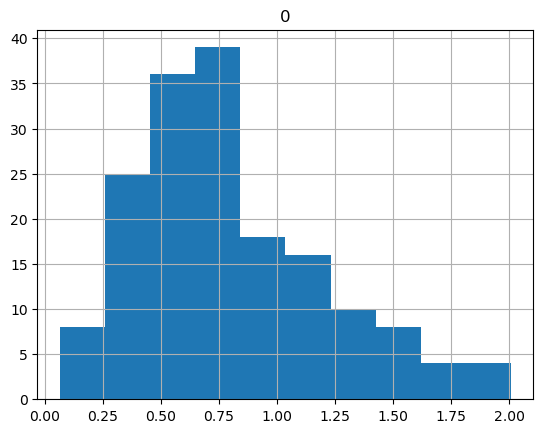

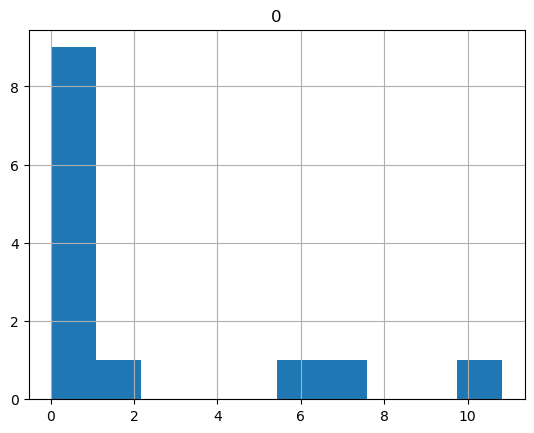

In [39]:
### question 1.
dfED = pd.DataFrame(ED[0])
dfED_plot = dfED.hist()
i = 0;

dfIM = pd.DataFrame(IM[:,i])
dfIM_plot = dfIM.hist()

In [94]:
### question 2.

# Concatenate
X = np.hstack((IM.T, ED.T))


# Calculating mean manually
mutest = [np.sum(X[:, i])/X.shape[0] for i in range(X.shape[1])]

# Calculating using np.mean
mu = np.mean(X, axis = 0)

print(mutest)
print(mu)

[0.5682651240593068, 4.905019490990694, 0.4120941974697712, 0.25109880835225223, 0.24023809523809522, 4.799136904761904, 0.3764887669766761, 0.3515210346701923, 0.19568252993022672, 6.27327271580386, 0.21995110203793025, 0.16393820057018488, 0.005479230746290455, 0.8024697185617264]
[5.68265124e-01 4.90501949e+00 4.12094197e-01 2.51098808e-01
 2.40238095e-01 4.79913690e+00 3.76488767e-01 3.51521035e-01
 1.95682530e-01 6.27327272e+00 2.19951102e-01 1.63938201e-01
 5.47923075e-03 8.02469719e-01]


<AxesSubplot: >

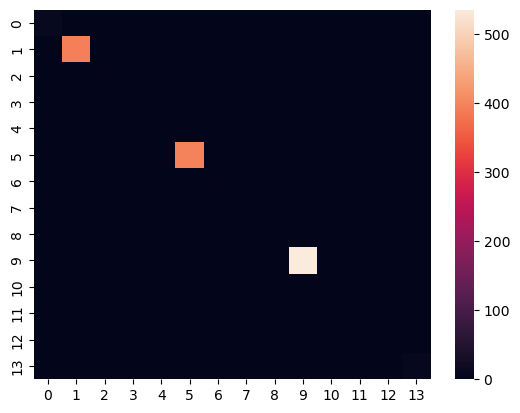

In [95]:
### question 3.
n = X.shape[0]
t = X.shape[1]
delta = np.eye(n)/t
Vxx = X.T@delta@X - np.tensordot(mu,mu, axes = 0)
dVxxd = Vxx.diagonal()
Dxx = np.diag(dVxxd)
dfDxx = pd.DataFrame(Dxx)
sns.heatmap(dfDxx)

In [97]:
### question 4.
Rxx = np.sqrt(np.linalg.inv(Dxx))@Vxx@np.sqrt(np.linalg.inv(Dxx))
print(Rxx)

[[1.         0.79901593 0.73958369 0.83594829 0.65217052 0.62348088
  0.89756498 0.70648385 0.89269567 0.47698411 0.90514276 0.79901593
  0.79901593 0.76768085]
 [0.79901593 1.         0.71450817 0.95198983 0.68339995 0.66952913
  0.93327413 0.71433862 0.78738214 0.70355901 0.82332691 1.
  1.         0.95835097]
 [0.73958369 0.71450817 1.         0.74442093 0.87426299 0.87211386
  0.82315119 0.96233238 0.90076395 0.64251913 0.8995399  0.71450817
  0.71450817 0.7979707 ]
 [0.83594829 0.95198983 0.74442093 1.         0.71672404 0.68970789
  0.96115588 0.71724293 0.82163612 0.69841057 0.85680259 0.95198983
  0.95198983 0.94171564]
 [0.65217052 0.68339995 0.87426299 0.71672404 1.         0.81273127
  0.75474866 0.83714897 0.7880791  0.66835547 0.82670275 0.68339995
  0.68339995 0.77079497]
 [0.62348088 0.66952913 0.87211386 0.68970789 0.81273127 1.
  0.74398176 0.85186072 0.73325441 0.7760732  0.77570241 0.66952913
  0.66952913 0.76932573]
 [0.89756498 0.93327413 0.82315119 0.96115588 0.75

In [98]:
### question 5.

'''D represents the covariance of the individual measures'''

print(Vxx)

[[1.14555664e+01 5.35381615e+01 4.42146737e+00 2.81339847e+00
  2.28953211e+00 4.19946370e+01 4.62997261e+00 3.62864259e+00
  2.93284895e+00 3.73383754e+01 3.13438915e+00 1.78938124e+00
  5.98056626e-02 7.80998927e+00]
 [5.35381615e+01 3.91921838e+02 2.49849074e+01 1.87402589e+01
  1.40330465e+01 2.63773777e+02 2.81587389e+01 2.14603862e+01
  1.51308482e+01 3.22139130e+02 1.66762959e+01 1.30990225e+01
  4.37802579e-01 5.70276878e+01]
 [4.42146737e+00 2.49849074e+01 3.11990685e+00 1.30747362e+00
  1.60173328e+00 3.06553593e+01 2.21592300e+00 2.57946466e+00
  1.54440000e+00 2.62482344e+01 1.62561912e+00 8.35059018e-01
  2.79097918e-02 4.23661700e+00]
 [2.81339847e+00 1.87402589e+01 1.30747362e+00 9.88751360e-01
  7.39218469e-01 1.36480670e+01 1.45660439e+00 1.08228962e+00
  7.93050881e-01 1.60619243e+01 8.71669542e-01 6.26347016e-01
  2.09341070e-02 2.81465243e+00]
 [2.28953211e+00 1.40330465e+01 1.60173328e+00 7.39218469e-01
  1.07585709e+00 1.67759323e+01 1.19311934e+00 1.31769140e+00


Provided that both $\mathbf{V}_{xx}$ and $\mathbf{R}_{xx}$ are positive definite, their eigenvalues $\lambda_i$ are associated to the eigenvectors $\mathbf{v}_i$ and $\mathbf{u}_i=\mathbf{D}_{xx}^{\frac{1}{2}}\mathbf{v}_i\mathbf{D}_{xx}^{\frac{1}{2}}$:
$$\mathbf{V}_{xx}\mathbf{v}_i=\lambda_i\mathbf{D}_{xx}\mathbf{v}_i \qquad \mathbf{R}_{xx}\mathbf{u}_i=\lambda_i\mathbf{u}_i  $$

__EXERCISE__

6. Compute the _main factors_ $\mathbf{v}_i$ (Hint: use the `numpy` function `eigh` and sort the eigenvalues in descending order)
7. Compute the _principal directions_ $\mathbf{a}_i=\mathbf{D}_{xx}\mathbf{v}_i$
7. Verify numerically that $\mathbf{v}_i^T\mathbf{a}_j=\delta_{ij}$ 
8. Compute the _principal components_ $\mathbf{c}_i=\mathbf{X}\mathbf{v}_i$
10. Verify numerically that:
$$\lambda_i\boldsymbol{\Delta}\mathbf{c}_i=\boldsymbol{\Delta}\mathbf{X}\mathbf{D}_{xx}^{-1}\mathbf{X}^{T}\boldsymbol{\Delta}\mathbf{c}_i$$
11. What is the analytical value of $s_{c_i}^2=\mathbf{c}_i^T\boldsymbol{\Delta}\mathbf{c}_i$ (the variance of the i$^\text{th}$ component)?
12. Why are the eigenvalues called "explained variances"?
13. What is the value of the following expression (analytical and numerical):
$$\sum_{j=1}^n \rho^2(\mathbf{x}_j,\mathbf{c}_i)$$
(recall that $\rho(\mathbf{x}_j,\mathbf{c}_i)$ is the correlation coefficient between the i$^\text{th}$ component and the $\mathbf{x}_j$ variable observed, and it reads:
$$\rho(\mathbf{x}_j,\mathbf{c}_i)=\frac{\mathbf{x}^T_j\boldsymbol{\Delta}\mathbf{c}_i}{s_{c_i}s_{x_j}}$$

In [121]:
### question 6.
eigD, eigvD = np.linalg.eigh(Dxx)
eigV, eigvV = np.linalg.eigh(Vxx)
index = eigV.argsort()[::-1]

eigV = eigV[index]
eigvV = eigvV[:, index]


In [122]:
### question 7.
av = [Dxx@eigvV[i, :] for i in range(eigvV.shape[1])]

The relation holds? True


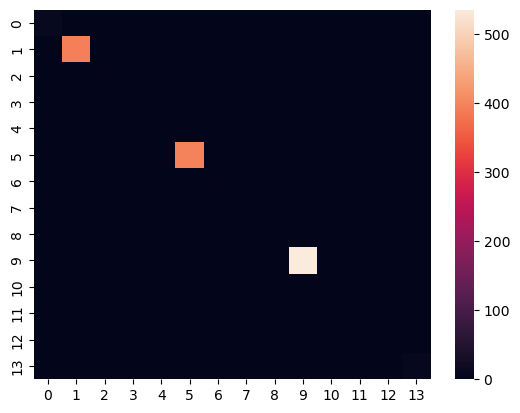

In [123]:
### question 8.

deltatest = (eigvV.T@av)
Dxxtest = np.diag(deltatest.diagonal())
dfDxxtest = pd.DataFrame(Dxxtest)
sns.heatmap(dfDxxtest)


# Check with Dxx to see if the relation holds

print("The relation holds?", np.allclose(np.sort(Dxx), np.sort(Dxxtest)))




In [127]:
### question 9.
c = [X@eigvV[i,:] for i in range(eigvV.shape[1])]
print(c[0])

[3.16932361 2.70246083 1.49460205 1.80405937 2.22624574 3.43372571
 3.69297563 2.57395522 1.4788676  1.0665572  1.5556126  1.40919829
 1.4167476  1.57207909 1.74487045 2.16781363 1.72365747 1.72570721
 2.03438499 1.16457042 0.85368574 0.8151149  3.60434433 3.28488488
 2.20446167 3.01959522 1.87985834 2.84271248 2.26110475 2.16667345
 3.39277019 1.88903025 2.75262147 2.37505611 1.56803383 1.29837133
 2.05342395 1.48232706 1.34281568 1.70362657 2.56648537 1.22900733
 1.70545735 1.60958654 2.1840755  2.89816748 1.67696085 1.38370176
 1.84375815 1.64449626 1.8310553  1.20461799 1.8442114  1.43069252
 1.26567785 1.38962407 1.64185848 1.46393706 1.13334807 0.91105584
 2.28455111 2.32585251 2.66204128 2.31163735 2.6456671  1.85351166
 0.84678599 1.38963965 1.8710631  1.33242195 2.89928517 2.62034052
 2.50052646 2.22659597 1.77268354 1.20905142 2.0872263  2.34939923
 2.62820957 1.79672837 3.81680166 2.41388241 2.03156024 1.21839914
 2.12358359 2.19292137 1.70886343 1.75511238 1.72059059 2.8473

In [ ]:
### question 10.

In [40]:
### question 11.

In [41]:
### question 12.

In [ ]:
### question 13.

### PCA with `sklearn`

`sklearn` is a `python3` library that easily computes the PCA, via the class [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), as briefly shown in the tutorial below:

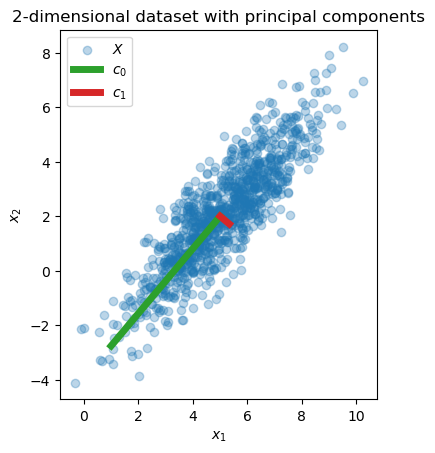

[-0.64331796 -0.76559911]


In [129]:
'''
PCA tutorial
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
rng = np.random.RandomState(0)
n_samples = 1000

Cxx = [[3, 3], [3, 4]]
mux = [5, 2]
X = rng.multivariate_normal(mean=mux, cov=Cxx, size=n_samples)
pca = PCA(n_components=2).fit(X)

c = pca.components_
sigma2 = pca.explained_variance_

plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="$X$")
for i, (comp, var) in enumerate(zip(c, sigma2)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [mux[0],mux[0]+ comp[0]],
        [mux[1],mux[1]+ comp[1]],
        label=r"$c_{:d}$".format(i),
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel=r"$x_1$",
    ylabel=r"$x_2$",
)
plt.legend()
plt.show()
print(c[0])

Text(0.5, 1.0, 'PCA of IRIS dataset')

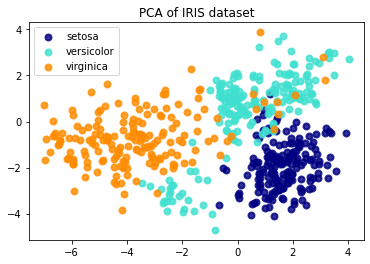

In [23]:
# Design PCA with two components
pca = PCA(n_components=2)

# Fit to the data and reconstruct
X_r = pca.fit(X).transform(X)

# Plot
plt.figure()


for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

__EXERCISE__

12. Compute the PCA via `sklearn` on the dataset $\mathbf{X}$
13. Plot the 




## References

[1] Saez, E. Lopez-Caballero, F. and Modaressi Farahmand-Razavi, A. (2011) *Effect of the inelastic dynamic soil–structure interaction on the seismic vulnerability assessment*. Structural Safety 33 (2011) 51-63. doi:10.1016/j.strusafe.2010.05.004